# Calculate the probability of Illinois drivers' age given race 

The python file should do the following:
- Calculate Pr(age|race). 
- Given race, draw the age distribution curve
- Draw the spline on the curve

We will do them one by one.

Feedback:
- ACS: Not all cook counties
- not look at sos
- Pr(age|race) = 

In [26]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = "/content/drive/MyDrive/Colab Notebooks/"

In [4]:
sos_data = pd.read_csv(path + "processed_sos.csv")
census_age = pd.read_csv(path+"census_age.csv")
census_race = pd.read_csv(path+"census_race.csv")

### Cleaning ACS-21 Chicago residents age data
Data is downloaded [**here**](https://data.census.gov/cedsci/table?q=chicago%20race%20age%20sex&tid=ACSST1Y2021.S0101)

In [104]:
census21_age = pd.read_excel(path+"acs21_age.xlsx", sheet_name = "Data", usecols = "A:B,D", skiprows = lambda x: x in [0, 1,2,3])
census21_age = census21_age.iloc[3:17,:]
census21_age.columns = ["age_group", "estimate", "perc (%)"]
census21_age.head(5)

,age_group,estimate,perc (%)
3,15 to 19 years,"147,958",5.5%
4,20 to 24 years,"188,295",7.0%
5,25 to 29 years,"269,990",10.0%
6,30 to 34 years,"248,720",9.2%
7,35 to 39 years,"215,854",8.0%


In [115]:
census21_age.dtypes

age_group     object
estimate       int64
perc (%)     float64
dtype: object

In [120]:
def remove_comma(df):
  for i in range(df.shape[0]):
    vals = df.iloc[i,1].split(",")
    if len(vals) >1:
      val1, val2 = vals
      val = val1 + val2
      df.iloc[i,1] = int(val)
  return df

In [ ]:
census21_age = remove_comma(census21_age)  

In [ ]:
census21_age = census21_age.astype({"estimate": "int", "perc (%)":"float"})
census21_age = census21_age.reset_index().iloc[:,1:]
census21_age.head(5)

In [108]:
def subtract_age_range(df):
  age_lst = []
  for i in range(df.shape[0]):
    range_lst = df.iloc[i,0].split()
    low = range_lst[0]
    max = range_lst[2]
    age_tuple = (low, max)
    age_lst.append(age_tuple)
    df.iloc[i,0] = low+ "-" + max
  return df, age_lst
census21_age, census_age_lst = subtract_age_range(census21_age)
census21_age.head(5)

,age_group,estimate,perc (%)
0,15-19,147958,5.5
1,20-24,188295,7.0
2,25-29,269990,10.0
3,30-34,248720,9.2
4,35-39,215854,8.0


In [109]:
census_age_lst

[('15', '19'),
 ('20', '24'),
 ('25', '29'),
 ('30', '34'),
 ('35', '39'),
 ('40', '44'),
 ('45', '49'),
 ('50', '54'),
 ('55', '59'),
 ('60', '64'),
 ('65', '69'),
 ('70', '74'),
 ('75', '79'),
 ('80', '84')]

In [154]:
census21_age.loc[:,'rel_perc (%)'] = census21_age.loc[:, "perc (%)"]/census21_age.loc[:, "perc (%)"].sum()*100
census21_age.loc[:,'rel_perc (%)'] = census21_age.loc[:,'rel_perc (%)'].apply(lambda x: round(x,2))
census21_age.head(5)

,age_group,estimate,perc (%),rel_perc (%)
0,15-19,147958,5.5,6.72
1,20-24,188295,7.0,8.56
2,25-29,269990,10.0,12.22
3,30-34,248720,9.2,11.25
4,35-39,215854,8.0,9.78


### Cleaning ACS-21 Chicago residents race data
Data is downloaded [**here**](https://data.census.gov/cedsci/table?q=chicago%20race)

***Problem:*** birace or multirace population: how to count them? (simply adding would result in overlapping)

In [140]:
acs21_race = pd.read_excel(path+"acs21_race.xlsx", sheet_name = "Data", usecols = "A:B,D", skiprows = lambda x: x in [0, 1,2,3])
acs21_race = acs21_race.iloc[0:6,:]
acs21_race.columns = ["race", "estimate"]
acs21_race

/usr/local/lib/python3.7/dist-packages/pandas/io/excel/_base.py:1292: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  **kwds,


,race,estimate
0,White alone,"863,622"
1,Black or African American alone,"787,551"
2,American Indian and Alaska Native alone,"3,332"
3,Asian alone,"189,857"
4,Native Hawaiian and Other Pacific Islander alone,529
5,Some Other Race alone,"11,536"


In [141]:
acs21_race.race = ['White',
       'Black or African American', 'American Indian and Alaska Native',
       'Asian', 'Native Hawaiian and Other Pacific Islander',
       'Some other race']
acs21_race

,race,estimate
0,White,"863,622"
1,Black or African American,"787,551"
2,American Indian and Alaska Native,"3,332"
3,Asian,"189,857"
4,Native Hawaiian and Other Pacific Islander,529
5,Some other race,"11,536"


In [142]:
acs21_race = remove_comma(acs21_race)
acs21_race = acs21_race.astype({"estimate": "int"})
#acs21_race.dtypes

In [143]:
acs21_race.loc[:, "perc (%)"] = acs21_race.estimate/acs21_race.estimate.sum()*100

In [144]:
acs21_race.loc[:, "perc (%)"] = acs21_race.loc[:, "perc (%)"].apply(lambda x: round(x, 2))

In [145]:
acs21_race.dtypes

race         object
estimate      int64
perc (%)    float64
dtype: object

In [146]:
acs21_race

,race,estimate,perc (%)
0,White,863622,46.52
1,Black or African American,787551,42.42
2,American Indian and Alaska Native,3332,0.18
3,Asian,189857,10.23
4,Native Hawaiian and Other Pacific Islander,529,0.03
5,Some other race,11536,0.62


In [151]:
acs21_race[acs21_race['race'] == "White"].iloc[:,2]

0    46.52
Name: perc (%), dtype: float64

### Calculating Pr(age|race)

We can roughly calculate the probably of age given race as the product of both. That is, Pr(age|race) = P(age)P(race)

**Note:** (This is not correct mathematically as $P(age|race) \neq P(age \cup race)$. These two are completely two distinct concepts. Should we follow a strict maethematical approach, then the formula shall be $P(age|race) = \frac{P(age \cup race)}{P(race)}$. For authors of the *Illinois Traffic and Pedestrian Stop Study*, they seemed to confuse two concepts as the same thing, which is untrue.) 

> "The second quantity needed was 𝑃𝑟(𝐴𝑔𝑒|𝑅𝑎𝑐𝑒). This was estimated by smoothing the estimated 
age distributions in Illinois for each racial group separately." (p.38)


In [212]:
def prob_age_given_race(race, age_group, relative_perc = True):
  """
  Calculate the probability of age given a race P(age|race)

  ------------------
  Input:
    race (str): 
          a race group of interest. The race group must match exactly the name of ACS
    age_group (str): 
          an age group of interest. The age group must match exactly the name of ACS
    relative_perc (boolean):
          if or not to use a relative percentage of the age group. Under a relative percentage,\n
          we only consider the proportion of this number over the selected age ranges (15-85) rather\n
          than the original age range in ACS (0-100)

  -------------------------------
  Output:
    p (float):  
          The conditional probability of age given race 
  """
  p_race = acs21_race[acs21_race['race'] == race].iloc[:,-1]/100

  if relative_perc:
    p_age = census21_age[census21_age['age_group'] == age_group].iloc[:,-1]/100
  else:
    p_age = census21_age[census21_age['age_group'] == age_group].iloc[:,-2]/100
  p = p_race.item()*p_age.item() # use .item() to convert a numpy float to Python float
  return p*100

In [216]:
prob_age_given_race("Asian", "30-34")

1.150875

In [217]:
def prob_age_race_table():
  race_lst = acs21_race.race.unique()
  age_lst = census21_age.age_group.unique()

  for race in race_lst:
    for age in age_lst:
      p = prob_age_given_race(race, age, relative_perc = True)
      print(f"For an Illinois resident who self-identify as a(n) {race}, \n the probability of this resident in age range {age} is {round(p,4)} %.")
prob_age_race_table()

For an Illinois resident who self-identify as a(n) White, 
 the probability of this resident in age range 15-19 is 3.1261 %.
For an Illinois resident who self-identify as a(n) White, 
 the probability of this resident in age range 20-24 is 3.9821 %.
For an Illinois resident who self-identify as a(n) White, 
 the probability of this resident in age range 25-29 is 5.6847 %.
For an Illinois resident who self-identify as a(n) White, 
 the probability of this resident in age range 30-34 is 5.2335 %.
For an Illinois resident who self-identify as a(n) White, 
 the probability of this resident in age range 35-39 is 4.5497 %.
For an Illinois resident who self-identify as a(n) White, 
 the probability of this resident in age range 40-44 is 3.9263 %.
For an Illinois resident who self-identify as a(n) White, 
 the probability of this resident in age range 45-49 is 3.2424 %.
For an Illinois resident who self-identify as a(n) White, 
 the probability of this resident in age range 50-54 is 3.3541 %.


[Text(0, 0, '0.0%'),
 Text(0, 0, '1.0%'),
 Text(0, 0, '2.0%'),
 Text(0, 0, '3.0%'),
 Text(0, 0, '4.0%'),
 Text(0, 0, '5.0%'),
 Text(0, 0, '6.0%')]

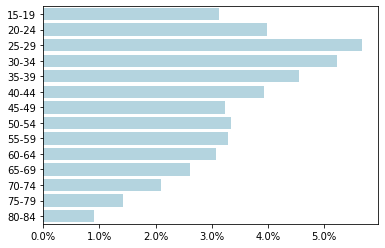

In [238]:
age_group = census21_age.age_group.unique()
#p = prob_age_given_race(race, age, relative_perc = True)
ax = sns.barplot(y = age_group, x = [prob_age_given_race("White", age) for age in age_group], color = "lightblue")
#plt.tlabel('Probability (%)')
vals = ax.get_xticks()
ax.set_xticklabels([str(y) + "%" for y in vals])

In [239]:
acs21_race.race[0]

'White'

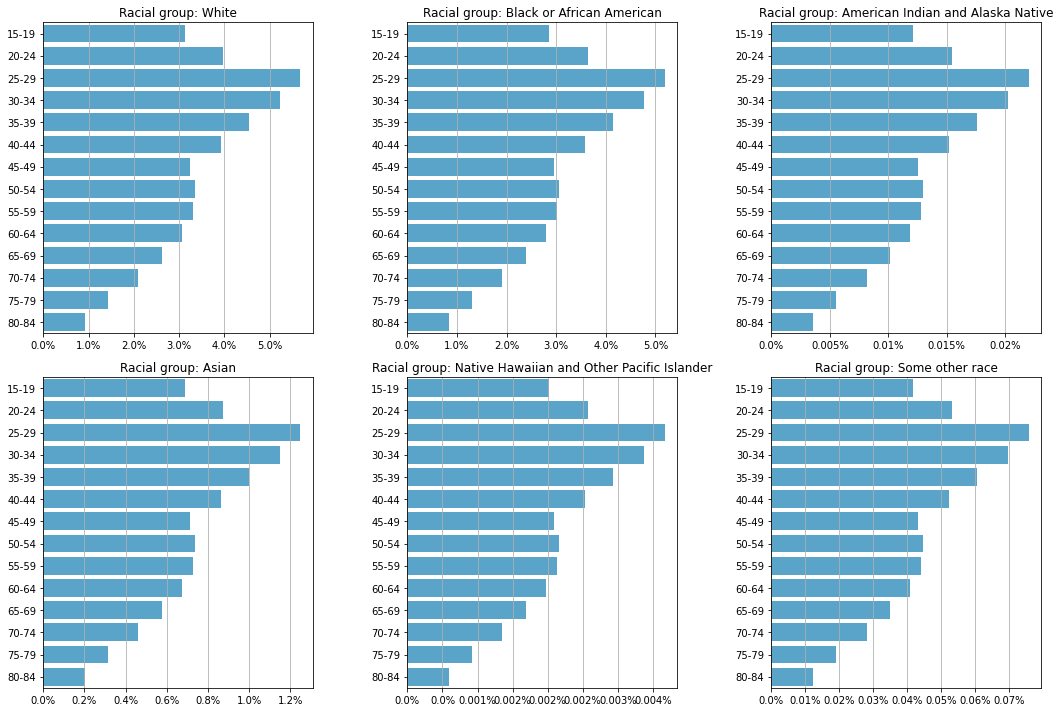

In [257]:
#plt.rcParams['figure.figsize'] = [15, 10]
age_group = census21_age.age_group.unique()

for i in range(len(acs21_race.race)):
    plt.subplot(2, 3 ,i+1)
    race = acs21_race.race[i]
    ax = sns.barplot(y = age_group, x = [prob_age_given_race(race, age) for age in age_group], color = "#46abdb")
    vals = ax.get_xticks()
    ax.set_xticklabels([str(round(y,3)) + "%" for y in vals])
    ax.grid(True, axis = "x")
    plt.title(f'Racial group: {race}')
plt.tight_layout()
plt.show()

### Parsing table from the Secretary of State pdf

In [6]:
census_data = census_age.merge(census_race, how = "left", on = "Block Group" )
census_data.head(5)

,Block Group,Total:_x,All: Under 5 years,All: 5 to 9 years,All: 10 to 14 years,All: 15 to 17 years,All: 18 and 19 years,All: 20 years,All: 21 years,All: 22 to 24 years,...,American Indian and Alaska Native,Asian,Native Hawaiian and Other Pacific Islander,Some other race,Two or more races,Hispanic or Latino,BG_Block_Group_num_y,BG_Census Tract_y,BG_County_y,BG_State_y
0,"Block Group 1, Census Tract 3018.01, Cook Coun...",1933,396,82,312,59,45,0,0,75,...,0,0,0,0,14,1886,1,3018.01,Cook County,Illinois
1,"Block Group 2, Census Tract 3018.02, Cook Coun...",1238,26,193,155,90,59,24,21,36,...,0,0,0,0,0,1191,2,3018.02,Cook County,Illinois
2,"Block Group 2, Census Tract 3018.03, Cook Coun...",1606,147,131,92,15,0,23,0,102,...,0,0,0,0,0,1606,2,3018.03,Cook County,Illinois
3,"Block Group 2, Census Tract 3102, Cook County,...",1009,83,40,31,14,0,0,0,23,...,0,135,0,0,6,445,2,3102.00,Cook County,Illinois
4,"Block Group 1, Census Tract 3105, Cook County,...",1434,107,70,86,22,16,0,17,109,...,0,7,0,0,0,1148,1,3105.00,Cook County,Illinois


In [8]:
census_data.iloc[:, [5,6]].sum()

All: 15 to 17 years     188610
All: 18 and 19 years    121506
dtype: int64

In [ ]:
census_data.columns

Index(['Block Group', 'Total:_x', 'All: Under 5 years', 'All: 5 to 9 years',
       'All: 10 to 14 years', 'All: 15 to 17 years', 'All: 18 and 19 years',
       'All: 20 years', 'All: 21 years', 'All: 22 to 24 years',
       'All: 25 to 29 years', 'All: 30 to 34 years', 'All: 35 to 39 years',
       'All: 40 to 44 years', 'All: 45 to 49 years', 'All: 50 to 54 years',
       'All: 55 to 59 years', 'All: 60 and 61 years', 'All: 62 to 64 years',
       'All: 65 and 66 years', 'All: 67 to 69 years', 'All: 70 to 74 years',
       'All: 75 to 79 years', 'All: 80 to 84 years', 'All: 85 years and over',
       'BG_Block_Group_num_x', 'BG_Census Tract_x', 'BG_County_x',
       'BG_State_x', 'Total:_y', 'Not Hispanic or Latino', 'White',
       'Black or African American', 'American Indian and Alaska Native',
       'Asian', 'Native Hawaiian and Other Pacific Islander',
       'Some other race', 'Two or more races', 'Hispanic or Latino',
       'BG_Block_Group_num_y', 'BG_Census Tract_y', 'BG_Co

## Getting Age Distribution of Drivers Pr(age = x) From the Secretary of State (SOS) data 

In [ ]:
sos_data.head(10)

,AGE,MALE,FEMALE,TOTAL,YEAR
0,15 & Younger,32970,34029,66999,2019
1,16,59171,60321,119492,2019
2,17,64897,65122,130019,2019
3,18,68861,66440,135301,2019
4,19,72495,69046,141541,2019
5,20,74848,70052,144900,2019
6,21,67926,65824,133750,2019
7,22,72222,69236,141458,2019
8,23,77481,74764,152245,2019
9,24,82995,80028,163023,2019


In [ ]:
sos_21 = sos_data[sos_data.loc[:, "YEAR"] == 2021].iloc[1:,:]
sos_21 = sos_21.astype({"AGE": "int"})
sos_21 = sos_21[sos_21.AGE < 85]

In [ ]:
sos_21.loc[:,"SHARE"] = sos_21.TOTAL/sos_21.TOTAL.sum()

Share is P(Driver, Age = x): the distribution of drivers' age



In [ ]:
sos_21 = sos_21.reset_index()
sos_21 = sos_21.iloc[:,1:]
sos_21.head(5)

,AGE,MALE,FEMALE,TOTAL,YEAR,SHARE
0,16,55600,55958,111558,2021,0.012742
1,17,62332,61865,124197,2021,0.014186
2,18,65644,63481,129125,2021,0.014749
3,19,68759,65467,134226,2021,0.015331
4,20,72707,69039,141746,2021,0.016190


In [ ]:
sos_21.sort_values(by = "SHARE", ascending=False) # look at max and min values

,AGE,MALE,FEMALE,TOTAL,YEAR,SHARE
9,25,83519,80764,164283,2021,0.018765
13,29,82944,80883,163827,2021,0.018712
17,33,82022,80589,162611,2021,0.018574
16,32,80240,80121,160361,2021,0.018317
25,41,79041,80032,159073,2021,0.018169
...,...,...,...,...,...,...
64,80,21684,23733,45417,2021,0.005188
65,81,18630,20176,38806,2021,0.004432
66,82,16746,18315,35061,2021,0.004005
67,83,14145,15471,29616,2021,0.003383


In [ ]:
sos_21.dtypes

AGE         int64
MALE        int64
FEMALE      int64
TOTAL       int64
YEAR        int64
SHARE     float64
dtype: object

In [ ]:
num_driver = sum(sos_21.iloc[:,-3])
num_driver

8754982

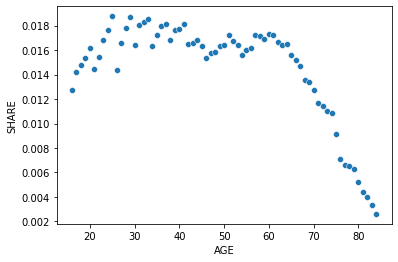

In [ ]:
sns.scatterplot(data=sos_21, x = "AGE", y = "SHARE")

## Getting from Census data

In [ ]:
census_data.columns

Index(['Block Group', 'Total:_x', 'All: Under 5 years', 'All: 5 to 9 years',
       'All: 10 to 14 years', 'All: 15 to 17 years', 'All: 18 and 19 years',
       'All: 20 years', 'All: 21 years', 'All: 22 to 24 years',
       'All: 25 to 29 years', 'All: 30 to 34 years', 'All: 35 to 39 years',
       'All: 40 to 44 years', 'All: 45 to 49 years', 'All: 50 to 54 years',
       'All: 55 to 59 years', 'All: 60 and 61 years', 'All: 62 to 64 years',
       'All: 65 and 66 years', 'All: 67 to 69 years', 'All: 70 to 74 years',
       'All: 75 to 79 years', 'All: 80 to 84 years', 'All: 85 years and over',
       'BG_Block_Group_num_x', 'BG_Census Tract_x', 'BG_County_x',
       'BG_State_x', 'Total:_y', 'Not Hispanic or Latino', 'White',
       'Black or African American', 'American Indian and Alaska Native',
       'Asian', 'Native Hawaiian and Other Pacific Islander',
       'Some other race', 'Two or more races', 'Hispanic or Latino',
       'BG_Block_Group_num_y', 'BG_Census Tract_y', 'BG_Co

In [ ]:
census_data.shape

(4002, 43)

In [ ]:
census_age = census_data[[col for col in census_data.columns if "All:" in col]]
#census_age.loc[:, "All"] = 
lst = []
for i in range(census_age.shape[0]):
  lst.append(sum(census_age.iloc[i,:]))
census_age.loc[:, "All"] = lst
census_age.head(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,All: Under 5 years,All: 5 to 9 years,All: 10 to 14 years,All: 15 to 17 years,All: 18 and 19 years,All: 20 years,All: 21 years,All: 22 to 24 years,All: 25 to 29 years,All: 30 to 34 years,...,All: 55 to 59 years,All: 60 and 61 years,All: 62 to 64 years,All: 65 and 66 years,All: 67 to 69 years,All: 70 to 74 years,All: 75 to 79 years,All: 80 to 84 years,All: 85 years and over,All
0,396,82,312,59,45,0,0,75,222,142,...,59,0,0,37,0,41,70,0,13,1933
1,26,193,155,90,59,24,21,36,92,43,...,34,1,7,9,19,31,30,1,0,1238
2,147,131,92,15,0,23,0,102,231,228,...,54,23,46,36,0,51,89,0,8,1606
3,83,40,31,14,0,0,0,23,157,196,...,57,39,25,51,8,7,0,0,16,1009
4,107,70,86,22,16,0,17,109,198,235,...,38,0,28,33,56,35,28,7,0,1434


In [ ]:
total_pop = sum(census_age.iloc[:,-1])
total_pop

5169517

In [ ]:
total_whites = sum(census_data.loc[:,"White"])
total_blacks = sum(census_data.loc[:,"Black or African American"])
total_asian = sum(census_data.loc[:, "Asian"])
total_americanindian = sum(census_data.loc[:, "American Indian and Alaska Native"])
total_pacific = sum(census_data.loc[:, "Native Hawaiian and Other Pacific Islander"])
total_hispanic = sum(census_data.loc[:, "Hispanic or Latino"])

In [ ]:
age5 = sum(census_data.loc[:,"All: Under 5 years"])
age5_9 =  sum(census_data.loc[:,"All: 5 to 9 years"])
age10_14 =  sum(census_data.loc[:,"All: 10 to 14 years"])
age15_17 =  sum(census_data.loc[:,"All: 15 to 17 years"])
age18_19 =  sum(census_data.loc[:,"All: 18 and 19 years"])
age20  =  sum(census_data.loc[:,"All: 20 years"])
age21 =  sum(census_data.loc[:,"All: 21 years"])
age22_24 =  sum(census_data.loc[:,"All: 22 to 24 years"])
age25_29 =   sum(census_data.loc[:,"All: 25 to 29 years"])
age30_34=  sum(census_data.loc[:,"All: 30 to 34 years"])
age35_39 = sum(census_data.loc[:,"All: 35 to 39 years"])
age40_44 = sum(census_data.loc[:,"All: 40 to 44 years"])
age45_49 = sum(census_data.loc[:,"All: 45 to 49 years"])
age50_54 = sum(census_data.loc[:,"All: 50 to 54 years"])
age55_59 = sum(census_data.loc[:,"All: 55 to 59 years"])
age60_61 = sum(census_data.loc[:,"All: 60 and 61 years"])
age62_64 = sum(census_data.loc[:,"All: 62 to 64 years"])
age65_66 =  sum(census_data.loc[:,"All: 65 and 66 years"])
age67_69 = sum(census_data.loc[:,"All: 67 to 69 years"])
age70_74 = sum(census_data.loc[:,"All: 70 to 74 years"])
age75_79 = sum(census_data.loc[:,"All: 75 to 79 years"])
age80_84 = sum(census_data.loc[:,"All: 80 to 84 years"])
age85 = sum(census_data.loc[:,"All: 85 years and over"])

In [ ]:
pop_age_lst = [
age15_17,
age18_19,
age20, 
age21, 
age22_24, 
age25_29, 
age30_34,
age35_39,
age40_44,
age45_49,
age50_54,
age55_59,
age60_61,
age62_64,
age65_66,
age67_69, 
age70_74,
age75_79,
age80_84] 
age_lst

[188610,
 121506,
 60065,
 63106,
 211282,
 432731,
 412096,
 366204,
 333521,
 326309,
 321429,
 330348,
 130989,
 173618,
 109098,
 138833,
 185932,
 129391,
 90243]

In [ ]:
driver15_17 = sos_21.query('AGE >= 15 and AGE <=17').TOTAL.sum()
driver18_19 = sos_21.query('AGE >= 18 and AGE <=19').TOTAL.sum()
driver20 = sos_21.query('AGE == 20').TOTAL
driver21 = sos_21.query('AGE == 21').TOTAL
driver22_24 = sos_21.query('AGE >= 22 and AGE <= 24').TOTAL.sum()
driver25_29 = sos_21.query('AGE >= 25 and AGE <=29').TOTAL.sum()
driver30_34 = sos_21.query('AGE >= 30 and AGE <=34').TOTAL.sum()
driver35_39 = sos_21.query('AGE >= 35 and AGE <=39').TOTAL.sum()
driver40_44 = sos_21.query('AGE >= 40 and AGE <=44').TOTAL.sum()
driver45_49 = sos_21.query('AGE >= 45 and AGE <=49').TOTAL.sum()
driver50_54 = sos_21.query('AGE >= 50 and AGE <=54').TOTAL.sum()
driver55_59 = sos_21.query('AGE >= 55 and AGE <=59').TOTAL.sum()
driver60_61 = sos_21.query('AGE >= 60 and AGE <=61').TOTAL.sum()
driver62_64 = sos_21.query('AGE >= 62 and AGE <=64').TOTAL.sum()
driver65_66 = sos_21.query('AGE >= 65 and AGE <=66').TOTAL.sum()
driver67_69 = sos_21.query('AGE >= 67 and AGE <=69').TOTAL.sum()
driver70_74 = sos_21.query('AGE >= 70 and AGE <=74').TOTAL.sum()
driver75_79 = sos_21.query('AGE >= 75 and AGE <=79').TOTAL.sum()
driver80_84 = sos_21.query('AGE >= 80 and AGE <=84').TOTAL.sum()

In [ ]:
driver_age_lst = [driver15_17,
driver18_19,
driver20,
driver21,
driver22_24,
driver25_29,
driver30_34,
driver35_39,
driver40_44,
driver45_49,
driver50_54,
driver55_59,
driver60_61,
driver62_64,
driver65_66,
driver67_69,
driver70_74,
driver75_79,
driver80_84]

In [ ]:
age_lst = [(15,17), (18,19), 20, 21, (22,24), (25,29), (30,34), (35,39), (40,44), (45,49), (50,54), (55,59), (60,61), (63,64),
 (65,66), (67,69), (70,74), (75,59), (80,84)]

prob_lst = []
for i in range(len(driver_age_lst)):
  p = driver_age_lst[i]/pop_age_lst[i]
  #p = round(p, 4)
  prob_lst.append(p)
prob_lst


[1.2499602354063941, 2.1673909107369185, 4    2.359877
 Name: TOTAL, dtype: float64, 5    2.005388
 Name: TOTAL, dtype: float64, 2.067521132893479, 1.7461402118175033, 1.8618501514210282, 2.0975740297757532, 2.253576236578806, 2.13672316730461, 2.242647676469765, 2.209730344969547, 2.309560344761774, 2.4989862802244005, 2.4676896001759885, 2.6320111212752013, 2.7193006045220836, 2.408459630113377, 1.903693361257937]

In [ ]:
prob_lst[0]

1.2499602354063941